## Utilities plotting

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import math
from matplotlib.collections import PatchCollection
import os.path as osp

In [48]:
def dict_to_state(state_dict):
    #neigh = info['neighbours'][0]
    neigh = 1
    features = 6
    state = 0
    for k in range(neigh):
        state += state_dict[k]*(features**k)
        
    return state

def preprocessing(bird, data_folder="data", filename_base="value_policy"):
    info = pd.read_csv(osp.join(data_folder,"env_info.csv"))
    episodes=info['episodes_num'][0]
    states=info['state_space_dim'][0]
    episodes_step=info['episode_write_step'][0]
    df = pd.read_csv(osp.join(data_folder, filename_base + str(bird) +".csv"))
    df["State"] = [i%states for i in range(episodes*states//episodes_step)]
    df["Episode"] = [(i//states)*episodes_step for i in range(episodes*states//episodes_step)]
    index = ['Episode', 'State']
    df.set_index(index, inplace=True)
    return df

#Extract policy
def extract_policy(df):
    d = df[["left", "straight", "right"]]
    d = d.unstack("State")
    #Softmax
    m = d.mean(axis=1, level=1)
    d = d.subtract(m,axis=0)
    d = d.apply(np.exp)
    s = d.sum(axis=1, level=1)
    d = d.divide(s,axis=0)
    return d

def extract_value(df):
    d = df["value"]
    d = d.unstack("State")
    return d

In [49]:
def value(bird,state=None):
    plt.style.use('fivethirtyeight')
    df = preprocessing(bird)
    df_val = extract_value(df)
    print(df_val.head(20))
    if(state is not None):
        df_val = df_val[dict_to_state(state)]
    else :
        df_val = df_val.loc[:, (df_val != df_val.iloc[0]).any()]
    #steady_df = df_val[-10:].mean()
    #df_val = df_val - steady_df
    df_val.plot(legend=True, title="Bird_"+str(bird)+" value", ylabel="V - V[steady]")

State           0           1           2           3           4   \
Episode                                                              
0         -1.93502   -0.719083   -0.484214   -0.401081   -0.203643   
2000     179.45200  155.996000  254.272000  272.881000  163.206000   
4000     295.13600  281.859000  330.065000  344.385000  284.572000   
6000     281.59700  290.995000  325.604000  331.401000  291.874000   
8000     221.85600  241.664000  293.163000  304.126000  250.542000   

State            5           6    7    8    9   ...   39   40   41   42   43  \
Episode                                         ...                            
0         -0.458127   -0.762472  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
2000     235.345000  246.000000  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
4000     330.537000  335.159000  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
6000     318.855000  322.894000  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
8000     297.177000  301.5250

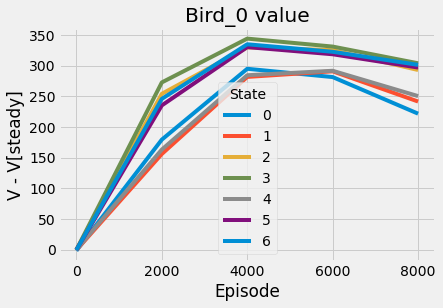

In [54]:
#value(0,{0:2,1:2,2:2,3:1})
value(0)

In [53]:
df = extract_policy(preprocessing(0))

In [54]:
df = df.swaplevel(0,axis=1)
#df.columns
df_tmp = df.groupby(level=0,axis=1).idxmax(axis=1)
df_max_policy = df_tmp.applymap(lambda x: x[1])

In [55]:
df_max_policy

State,0,1,2,3,4,5,6,7,8,9,10,11,12
Episode,,,,,,,,,,,,,
0,left,left,left,left,left,left,straight,left,left,right,right,left,left
1000,left,left,left,left,left,left,right,right,left,straight,right,left,left
2000,left,left,left,left,left,left,right,left,left,straight,right,left,left
3000,left,left,left,left,left,left,right,right,left,straight,left,left,left
4000,left,left,left,left,left,left,right,right,left,straight,left,left,left
5000,left,left,left,left,left,left,right,left,left,straight,left,left,left
6000,left,left,left,left,left,left,right,left,left,straight,left,left,left
7000,left,left,left,left,left,left,right,right,left,straight,left,left,left
8000,left,left,left,left,left,left,right,right,left,right,right,left,left


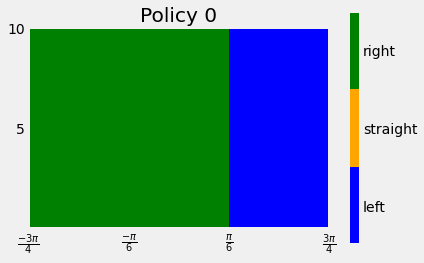

In [50]:
bird = 0
col_dict={1:"blue",
          2:"orange",
          3:"green"}

df = extract_policy(preprocessing(bird))
df = df.swaplevel(0,axis=1)
#df.columns
df_tmp = df.groupby(level=0,axis=1).idxmax(axis=1)
df_max_policy = df_tmp.applymap(lambda x: x[1])
df_max_policy = df_max_policy.applymap(lambda x: 1 if x=='left' else x)
df_max_policy = df_max_policy.applymap(lambda x: 2 if x=='straight' else x)
df_max_policy = df_max_policy.applymap(lambda x: 3 if x=='right' else x)
last_policy = df_max_policy.iloc[len(df_max_policy)-1]
tmp = last_policy[6:12].to_numpy().reshape(2,3)
extent = 0, 3, 0, 2
fig, ax = plt.subplots()
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
labels = ['left','straight','right']
norm = colors.BoundaryNorm(norm_bins, len(labels), clip=True)
fmt = ticker.FuncFormatter(lambda x,pos: labels[norm(x)]) #returns the correct label for tick x and position pos
cm = colors.ListedColormap([col_dict[x] for x in col_dict.keys()])
im = ax.imshow(tmp, cmap=cm, norm=norm, origin='lower')
#ax.set_xticks(ticks=[0,1,2])
ax.set_xticks(ticks=[-0.5,0.5,1.5,2.5])
ax.set_xticklabels(labels=[r'$\frac{-3\pi}{4}$',r'$\frac{-\pi}{6}$',r'$\frac{\pi}{6}$',r'$\frac{3\pi}{4}$'])
ax.set_yticks(ticks=[0.5,1.5])
ax.set_yticklabels(labels=[5,10])
ax.set_title('Policy '+str(bird))
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
ax.grid(linestyle='-',linewidth=2)
cb = fig.colorbar(im, format=fmt, ticks=tickz)
plt.show()

In [9]:
col_dict={1:"blue",
          2:"orange",
          3:"green"}

norm_bins = np.sort([*col_dict.keys()]) + 0.5


In [10]:
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

[0.5 1.5 2.5 3.5]
[[3 2 1]
 [3 3 1]]


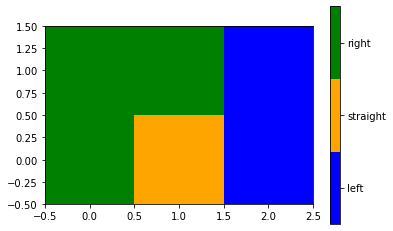

In [117]:
fig, ax = plt.subplots()
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
labels = ['left','straight','right']
norm = colors.BoundaryNorm(norm_bins, len(labels), clip=True)
fmt = ticker.FuncFormatter(lambda x,pos: labels[norm(x)]) #returns the correct label for tick x and position pos
cm = colors.ListedColormap([col_dict[x] for x in col_dict.keys()])
im = ax.imshow(tmp, cmap=cm, norm=norm, origin='lower')
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(im, format=fmt, ticks=tickz)
plt.show()

In [114]:
labels

{'left', 'right', 'straight'}

AttributeError: 'AxesImage' object has no attribute 'show'

In [12]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

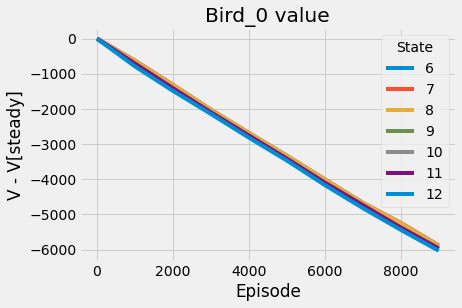

In [4]:
def state_re_conv(state):
    """
        Convert state to dictionary
    """
    #TODO: add sectors to info file
    info = pd.read_csv("data/env_info.csv")
    sectors = info["sectors"].item()
    base = info["states_per_sector"].item()
    is_directed = info["is_directed"].item()
    
    if(is_directed):
        base = base*2
        
    #base -= 1 #Base is the state per sector minus 1
    
    if(not is_directed):
        
        out_dict = {}
        #each key is the sector, having as element who is in it, be it a string or a tuple 
        for i in range(sectors):
            int_key = (state//(base**i))%base
            
            if(int_key == 0):
                out_dict[i] = 'none'
            elif(int_key == 1):
                out_dict[i] = 'foe'
            elif(int_key == 2):
                out_dict[i] == 'brother'
            elif(int_key == 3):
                out_dict[i] = 'both'
              
    else:
        
        out_dict = {}
        #each key is the sector, having as element who is in it, be it a string or a tuple 
        for i in range(sectors):
            #print(base**i)
            int_key = (state//(base**i))%base
            #print(int_key)
            
            if(int_key == 0 or int_key == (base)//2):
                out_dict[i] = 'none'
            elif(int_key == 1):
                out_dict[i] = 'foe_in'
            elif(base > 5 and int_key == 2):
                out_dict[i] = 'brother_in'
            elif(base > 7 and int_key == 3):
                out_dict[i] = 'both_in'
            elif(int_key == (base)//2+1):
                out_dict[i] = 'foe_out'
            elif(int_key == (base)//2+2):
                out_dict[i] = 'brother_out'
            elif(int_key == (base)//2+3):
                out_dict[i] = 'both_out'
    

    return out_dict

def obs_to_state(obs):
    """
        Transforms a dictionary defining an observation into the index of a state.
        Works only if observation is directed and we have overwrite mode on for now.
        The observation is defined like
        obs = {sector_num (int) : sector_status (['none','foe_in','foe_out','brother_in','brother_out'])}
    """
    info = pd.read_csv("data/env_info.csv")
    sectors = info["sectors"].item()
    is_directed = bool(info["is_directed"].item())     
    
    state = np.empty([sectors,1])
    for i in range(sectors): 
        if obs[i] == 'none':
            state[i] = 0
        if obs[i] == 'foe_in':
            state[i] = 1
        if obs[i] == 'brother_in':
            state[i] = 2
        if obs[i] == 'foe_out':
            state[i] = 3
        if obs[i] == 'brother_out':
            state[i] = 4
    
    state_num = 0

    for i in range(sectors):
        state_num+=state[i]*pow(5,i)
        
    return int(state_num)

{0: 'foe_in', 1: 'none', 2: 'none', 3: 'none', 4: 'none'}
{0: 'brother_out', 1: 'foe_in', 2: 'none', 3: 'none', 4: 'none'}
{0: 'brother_out', 2: 'foe_in', 1: 'none', 3: 'none', 4: 'none'}
{0: 'brother_out', 3: 'foe_in', 1: 'none', 2: 'none', 4: 'none'}
{0: 'brother_out', 4: 'foe_in', 1: 'none', 2: 'none', 3: 'none'}
{1: 'brother_out', 0: 'foe_in', 2: 'none', 3: 'none', 4: 'none'}
{1: 'foe_in', 0: 'none', 2: 'none', 3: 'none', 4: 'none'}
{1: 'brother_out', 2: 'foe_in', 0: 'none', 3: 'none', 4: 'none'}
{1: 'brother_out', 3: 'foe_in', 0: 'none', 2: 'none', 4: 'none'}
{1: 'brother_out', 4: 'foe_in', 0: 'none', 2: 'none', 3: 'none'}
{2: 'brother_out', 0: 'foe_in', 1: 'none', 3: 'none', 4: 'none'}
{2: 'brother_out', 1: 'foe_in', 0: 'none', 3: 'none', 4: 'none'}
{2: 'foe_in', 0: 'none', 1: 'none', 3: 'none', 4: 'none'}
{2: 'brother_out', 3: 'foe_in', 0: 'none', 1: 'none', 4: 'none'}
{2: 'brother_out', 4: 'foe_in', 0: 'none', 1: 'none', 3: 'none'}
{3: 'brother_out', 0: 'foe_in', 1: 'none', 2: 

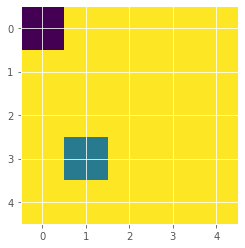

In [95]:
#def plot_policy(bird):
sectors = 5
df = preprocessing(1)
df = extract_policy(df)

left_df = df['left']
straight_df = df['straight']
right_df = df['right'].iloc[-1]

right_policy = np.empty((sectors,sectors)) #stick to case in which a prey sees predator and just one other prey
for i in range(sectors):
    for j in range(sectors):
        state = {i:'brother_out'}
        state[j] = 'foe_in'
        for k in range(sectors):
            if k not in (i,j):
                state[k] = 'none'
                
        print(state)
        state_id = obs_to_state(state)
        right_policy[i,j] = right_df[state_id]
                
print(right_policy)
plt.imshow(right_policy)

In [92]:
a = np.empty((2,2))
a[0,0] = 1
a

array([[  1.   , 170.408],
       [ 13.575, 180.408]])

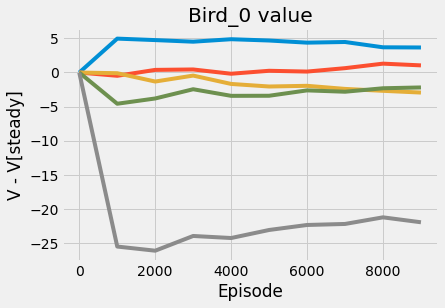

In [9]:
value_at_conv(0)

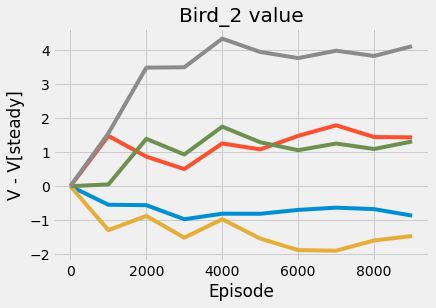

In [10]:
value_at_conv(2)

In [134]:
state_re_conv(729)

{0: 'none', 1: 'foe_in', 2: 'brother_in', 3: 'none', 4: 'none'}

In [ ]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,1)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

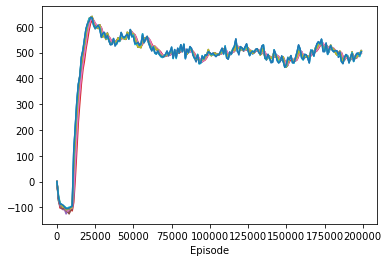

In [6]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,2)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

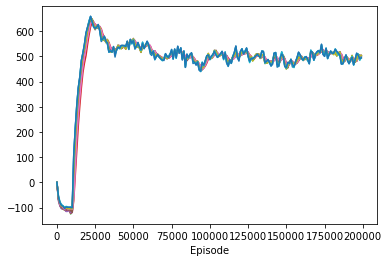

In [7]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,3)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

<AxesSubplot:xlabel='Episode'>

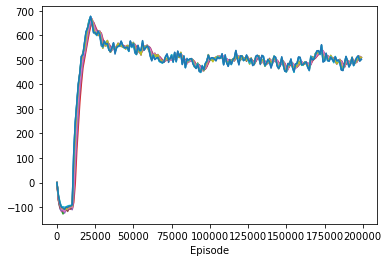

In [8]:
df = preprocessing(filename="data/value_policy.csv")
df_val = extract_value(df,4)
df_val.loc[:, (df_val != df_val.iloc[0]).any()].plot(legend=False)
#This is more convergent for policies

## Diagnostic tools

-30.00001285727039


,episode,bird,sec0,sec1,sec2
0,0,0,0,0,0
1,0,1,0,0,0
2,0,2,0,0,0
3,0,3,0,0,0
4,0,4,0,0,0


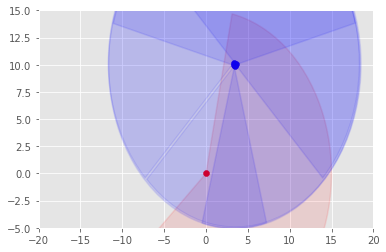

In [20]:
def select_frame(ep,frame=0,birds_num=10):
    df = pd.read_csv("data/pursuer_trajectory.csv")
    df = df[df["Episode"]==ep].iloc[frame]
    
    fig, ax = plt.subplots(1,1)
    patches = []
    
    ax.scatter(df["x"+str(0)],df["y"+str(0)], color="red")
    print(df["alpha"+str(0)]*180/math.pi)
    wedge = mpatches.Wedge((df["x"+str(0)], df["y"+str(0)]), 15, 
                           df["alpha"+str(0)]*180/math.pi - 6*18, df["alpha"+str(0)]*180/math.pi + 6*18, 
                           alpha=0.1, lw=1.5, color="red")
    patches.append(wedge)
    
    for i in range(1,birds_num):
        ax.scatter(df["x"+str(i)],df["y"+str(i)], color="blue")
        wedge = mpatches.Wedge((df["x"+str(i)], df["y"+str(i)]), 15, 
                           df["alpha"+str(i)]*180/math.pi - 135, df["alpha"+str(i)]*180/math.pi + 135, 
                           alpha=0.1, lw=1.5, color="blue")
        patches.append(wedge)
    
        
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    ax.set_xlim(-20,20)
    ax.set_ylim(-5,15)
        
    return ax

ep = 0
fr = 0
bn = 5
select_frame(ep, frame=fr, birds_num=bn)

df = pd.read_csv("data/observations.csv")
df = df[df["episode"]==ep]
df.iloc[fr*bn:(fr+1)*bn]

## Policy animation

In [33]:
df = preprocessing(0)
df

value      left  straight     right
Episode State                                        
0       0     -0.730847  0.021829  0.031946  0.027815
        1      0.000000  0.100000  0.100000  0.100000
        2      0.000000  0.100000  0.100000  0.100000
        3      0.000000  0.100000  0.100000  0.100000
        4      0.000000  0.100000  0.100000  0.100000
...                 ...       ...       ...       ...
99000   7771   0.000000  0.100000  0.100000  0.100000
        7772   0.000000  0.100000  0.100000  0.100000
        7773   0.000000  0.100000  0.100000  0.100000
        7774   0.000000  0.100000  0.100000  0.100000
        7775   0.000000  0.100000  0.100000  0.100000

[777600 rows x 4 columns]

In [34]:
def obs_to_state(obs, sec_num=5, state_per_sector=3):
    """
        Transforms a dictionary defining an observation into the index of a state.
        The observation is defined like
        obs = {'none':[0,1], 'evader':[bla], 'pursuer':[bla]}
    """
    state = np.empty([sec_num,1])
    for i in obs['none']:
        state[i] = 0
    for i in obs['foe']:
        state[i] = 1
    for i in obs['brother']:
        state[i] = 2
    for i in obs['both']:
        state[i] = 3
    
    state_num = 0

    for i in range(sec_num):
        state_num+=state[i]*pow(state_per_sector,i)
        
    return int(state_num)

def state_to_color(state, sec_num=5, base=3):
    col = ["white" for i in range(sec_num)]
    state_base = np.empty(sec_num)
    for i in range(0,sec_num):
        state_base[i] = (state//base**i)%base
    
    for i in range(sec_num):
        if state_base[i] == 0:
            col[i] = "white"
        elif state_base[i] == 1:
            col[i] = "red" #Now stands for foe
        elif state_base[i] == 2:
            col[i] = "blue"  #Now stands for brother
        elif state_base[i] == 3:
            col[i] = "purple"
            
    return col

def create_wedge(state, ax, sec_num=5, state_per_sector=3):

    patches = []
    
    # add the vision cone
    sector_angle = 180/(sec_num)
    min_ang = 0
    max_ang = sector_angle
    col = state_to_color(state, sec_num, state_per_sector)
    for i in range(sec_num):
        wedge = mpatches.Wedge((1, 1), 2, min_ang, max_ang, 
                               alpha=0.1, lw=1.5, color=col[i])
        min_ang += sector_angle
        max_ang += sector_angle
        patches.append(wedge)

    x = [2*math.cos(-math.pi/(sec_num)*i)+1 for i in range(1,sec_num)]
    y = [2*math.sin(math.pi/(sec_num)*i)+1 for i in range(1,sec_num)]

    for i in range(sec_num-1):
        ax.plot([1,x[i]],[1,y[i]], color="cornflowerblue", lw=0.3)
    
    t_p = np.array([[0,0], [1/2,math.sqrt(3)/2], [1,0]])*1/2  + np.array([3/4,1/2])
    
    # Simplex outside sectors
    t = mpatches.Polygon(t_p, alpha=0.2, lw=2)
    patches.append(t)
       
    return patches, t_p #, t_coord

In [ ]:
obs_to_state()

In [18]:
def plot_policy_ep(bird, obs, episode=-1, birds_num=2, sec_num=3, state_per_sector=2):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10,6))
    state = obs_to_state(obs, sec_num, state_per_sector)
    patches, t_p = create_wedge(state, ax, sec_num, state_per_sector)
    collection = PatchCollection(patches, match_original=True)
    
    plt.axis('equal')
    plt.axis('off')
    
    df = preprocessing(filename="data/value_policy.csv")
    df = extract_policy(df, bird)
    
    if episode == -1:
        df = df.iloc[-1] #Number of episode
    else :
        df = df.loc[episode]
    
    #df.reset_index(drop=True,inplace=True)
    x = (df[("right_"+str(bird),)] - df[("left_"+str(bird),)])/2 + 0.5
    y = df[("straight_"+str(bird),)]*math.sqrt(3)/2
    s_point = t_p[0] + np.array([x[state]/2, y[state]/2])
    ax.scatter(s_point[0], s_point[1])
    ax.add_collection(collection)

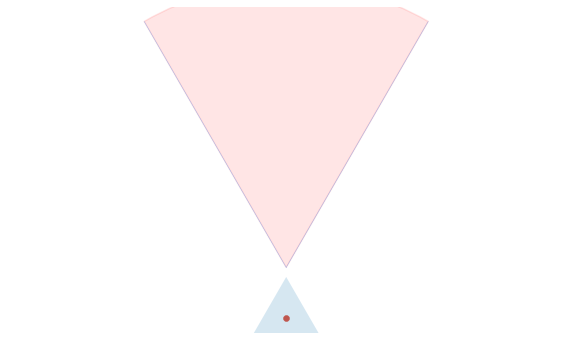

In [19]:
plot_policy_ep(0, {"none":[0,2], "foe":[1], "brother":[], "both":[]}, birds_num=2, sec_num=3, state_per_sector=2)

In [102]:
def animate_policy(bird, obs, birds_num=2, sec_num=3, base=1):
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    points = ax.scatter([], [], color="darkblue", s=sec_num)

    #patches, tp, t_coord = create_wedge(state)
    state = obs_to_state(obs)
    patches, t_p = create_wedge(state, ax, sec_num, base)

    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    plt.axis('equal')
    plt.axis('off')
    t = plt.text(-1,3,"Episode 0")
    t.set_color('red')
    plt.tight_layout()

    #Data preparation
    df = preprocessing(filename="data/value_policy.csv")
    df = extract_policy(df, bird)
    df.reset_index(drop=True,inplace=True)
    x = (df[("right_"+str(bird),)] - df[("left_"+str(bird),)])/2 + 0.5
    y = df[("straight_"+str(bird),)]*math.sqrt(3)/2
    sec_num = len(df)

    x = x[state]
    y = y[state]
    #print(x)

    def animate(i):
        #p = np.empty([6,2])
        s_point = t_p[0] + np.array([x[i]/2, y[i]/2])
        p = [s_point[0], s_point[1]]
        #p[0,:] = [s_point[0], s_point[1]]

        #for j,k in enumerate(sectors[:0:-1]):
            #s_point = t_coord[j] + np.array([x[k][i]/2, y[k][i]/2])
            #p[j+1,:] = [s_point[0][0], s_point[0][1]]

        points.set_offsets(p)
        t.set_text("Episode "+str(i*1000))
        if ((i*1000)//20000)%birds_num == 0:
            t.set_color('red')
        else:
            t.set_color('blue')
        return points,t,

    anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=20, blit=True)
    return anim

KeyError: 'pursuer'

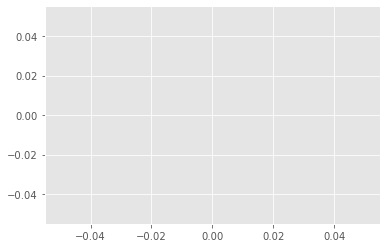

In [27]:
anim_p = animate_policy(1,{'none':[0,1,2], 'evader':[3]},birds_num=2)
HTML(anim_p.to_html5_video())